# 분류 순위 평가
- 컨퓨전 매트릭스 기반으로 한 분류의 기본적인 성능평가 지표
 - 정확도, 정밀도, 리콜, f-1 점수 등
- 분류 모델의 종합적인 성능 평가를 하기 위해서는 순위(랭킹)을 평가해야 한다
 - 이를 위해서 ROC-AUC, precision-recall curve, mAP 등을 사용한다
 - 최적의 분류 경계값(기준값: threshold) 설정이 필요하다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 10명의 환자 검진 예

In [2]:
# 검진 점수를 랜덤하게 배정 (점수가 클수록 암 발생일 가능성이 높다고 가정)
np.random.seed(19)
raw_scores = np.random.randint(30,99,10)

# 환자 명단(id)과 점수
df = pd.DataFrame({"점수":raw_scores})
df = df.sort_values(['점수'], ascending=False)

# 상위 4명을 암으로 예측
threshold =  65
pred_cancer = df["점수"] > threshold

# 진단 컬럼을 추가 (불리언을 숫자로 변환)
df["진단"] = pred_cancer.astype(int)
df['실제암발생'] = np.array([1,1,0,1,0,1,1,0,0,0])
df

,점수,진단,실제암발생
4,96,1,1
5,86,1,1
2,82,1,0
0,70,1,1
7,64,0,0
3,61,0,1
6,52,0,1
1,49,0,0
9,40,0,0
8,35,0,0


## 컨퓨전 매트릭스와 정적 성능 평가

In [4]:
y_pred = df['진단']
y_test = df['실제암발생']

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

show_clf_result(y_test, y_pred)

[[4 1]
 [2 3]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



## 다른 분류 경계치(threshold)를 선택한 경우
- 분류 경계치 65점을 변경하여 상위 1, 2, 3,.., 7 명을 각각 암 환자라고 진단한 경우 정적 성능 지표가 달라진다

In [5]:
# 상위 1~7 명을 암이라고 예측한 경우의 정적 성능 평가
y_pred = [1,0,0,0,0,0,0,0,0,0]
# y_pred = [1,1,0,0,0,0,0,0,0,0]
# y_pred = [1,1,1,0,0,0,0,0,0,0]
# y_pred = [1,1,1,1,0,0,0,0,0,0]
# y_pred = [1,1,1,1,1,0,0,0,0,0]
# y_pred = [1,1,1,1,1,1,0,0,0,0]
# y_pred = [1,1,1,1,1,1,1,0,0,0]

show_clf_result(y_test, y_pred)

[[5 0]
 [4 1]]
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.20      0.33         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



### 검토
- 분류 결정 경계치(threshold)를 다른 값으로 택하면 정확도, 정밀도, 리콜 등의 기본 성능 척도가 달라진다
- 즉, 모델의 실제적인 분류 능력에는 변함 없으면서, 성능을 다른 값으로 선택할 수 있다
- 분류 경계치를 낮게 정할수록 리콜은 증가하지만, 정밀도는 나빠진다. 반대로 분류 경계치를 높게 정할수록 정밀도는 증가하지만 리콜은 나빠진다

## 분류 순위 평가 방법
### ROC 커브

- 경계치를 한 샘플씩 낮추면서 positive 예측이 맞는지, 틀리는지를 2차원 평면에 그린 것을 ROC(Response of Characteristic) 커브라고 한다

- (0,0) 점에서 시작하여, 점수순으로 소팅한 테이블의 y_test 값을 하나씩 따라 내려오면서 positive를 맞추면 위로, 틀리면 우로 한 칸씩 이동하여 최종 (1,1) 지점에 도착한다
 - TRP: True Positive Rate
 - FPR: False Positive Rate
- 위로 올라갈 횟수는 전체 샘플수중에 positive 샘플수이고, 우로 이동할 횟수는 negative 샘플수이다
 
<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-03%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%209.15.05.png?raw=1" width=330 align='left'>

- 분류 모델의 순위를 맞추는 능력을 평가하면 모델의 전체적인 성능을 한번에 파악할 수 있다
- 정확도, 정밀도, 리콜 등은 분류 경계치를 얼마로 정하는가에 따라서 수시로 달라질 수 있는 값이다. 즉 선택의 문제이다

###  AUC
- ROC 평가 결과를 간단히 하나의 숫자로 표현하기 위해서 ROC 커브의 면적을 사용한다
- 이를 AUC (Area Under Curve)라고 하며 0~1 사이의 값을 갖는다

## 랭킹 평가를 하려면 점수가 필요하다
- 분류 예측에서 순위를 평가하려면 (즉, 예측치를 소팅하려면) 분류 결과가 특정 클래스에 속할 가능성을 나타내는 점수 또는 확률값이 필요하다
- (참고) 선형 계열 분류 모델은 분류 점수를 제공하고 결정 트리, 로지스틱 회귀, 신경망 계열 모델은 분류 확률을 제공한다

### 10명 환자 분류의 ROC 커브
- 환자 10명을 점수순으로 소팅한 결과와 실제 암환자 사실 정보 (y_test)를 이용하여 ROC 커브를 그린다
- roc_curve 함수를 사용한다

In [6]:
df

,점수,진단,실제암발생
4,96,1,1
5,86,1,1
2,82,1,0
0,70,1,1
7,64,0,0
3,61,0,1
6,52,0,1
1,49,0,0
9,40,0,0
8,35,0,0


In [7]:
# 10명 환자의 암환자일 점수 (인덱스 번호로 환자를 구분한다)
scores_10 = df['점수']
scores_10

4    96
5    86
2    82
0    70
7    64
3    61
6    52
1    49
9    40
8    35
Name: 점수, dtype: int64

### ROC 커브 그리기

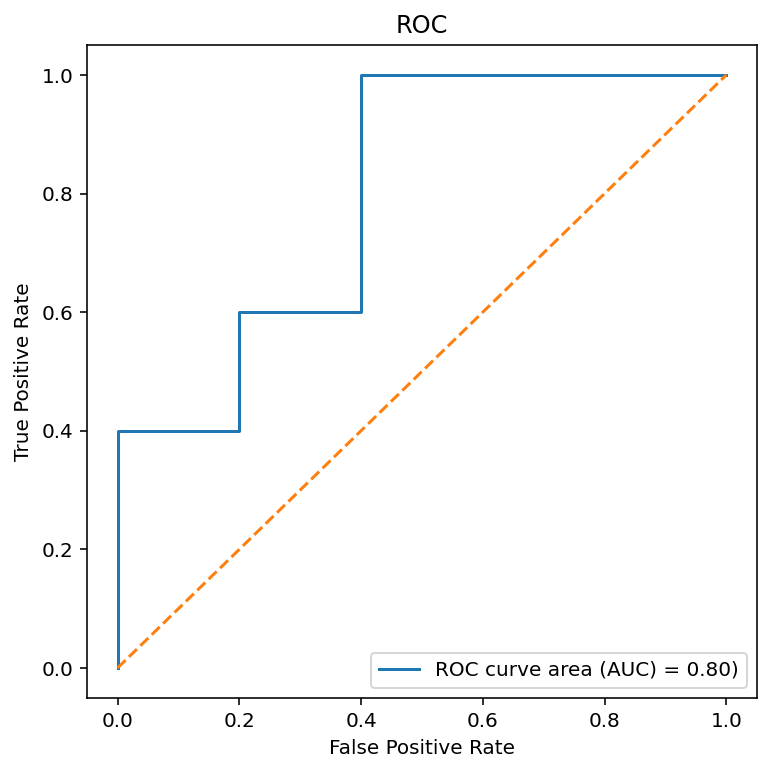

In [8]:
# ROC 커브를 그리기 위해서 roc_curve 함수를 사용한다
fpr, tpr, _ = roc_curve(y_test, scores_10)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve area (AUC) = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

- ROC 커브는 예측 점수순으로 소팅한 y_test 값, [1,1,0,1,0,1,1,0,0,0]의 [1,0] 순서만 알면 그릴 수 있다

## ROC 성능 비교 예

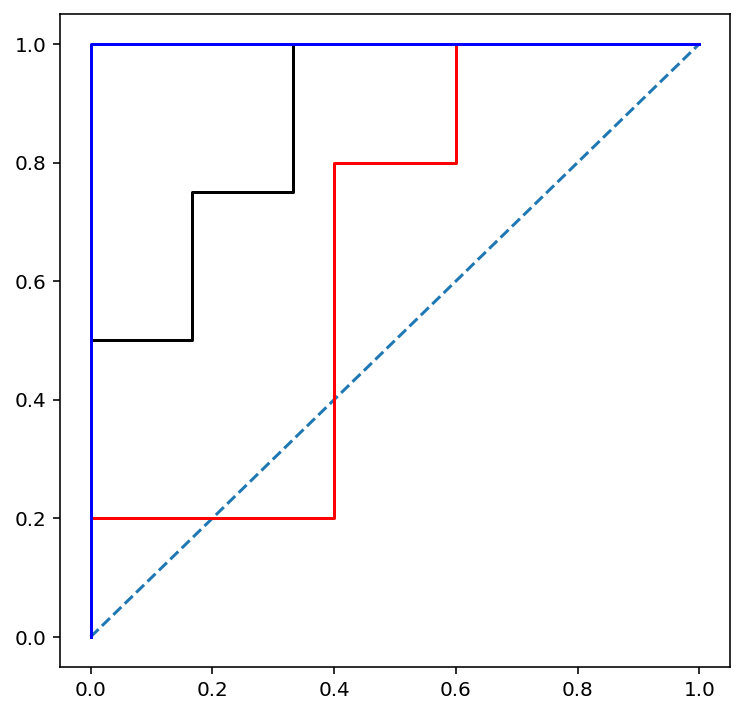

In [9]:
# 3명의 의사 실력을 비교
# 3명의 의사가 진단한 점수순으로 소팅했을 때 각각 실제 암환자를 찾아낸 순서가 아래와 같은 경우를 비교
# y_test의 앞쪽에서 (초반에) 암환자를 찾을수록 훌륭한 의사임

y_test_sample = [[1,0,0,1,1,1,0,1,0,0],
         [1,1,0,1,0,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0]]

plt.figure(figsize=(6,6))    
plt.plot([0, 1], [0, 1], linestyle='--')

my_color = ['r', 'k', 'b']
for i in range(len(y_test_sample)):
    fpr, tpr, _ = roc_curve(y_test_sample[i], scores_10)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c=my_color[i])

# Precision-Recall 곡선
- 분류 경계치(threshold)를 하나씩 내려면서 (또는 올리면서) 리콜과 정밀도를 2차원 평면에 그리는 것

In [10]:
y_test = df['실제암발생']

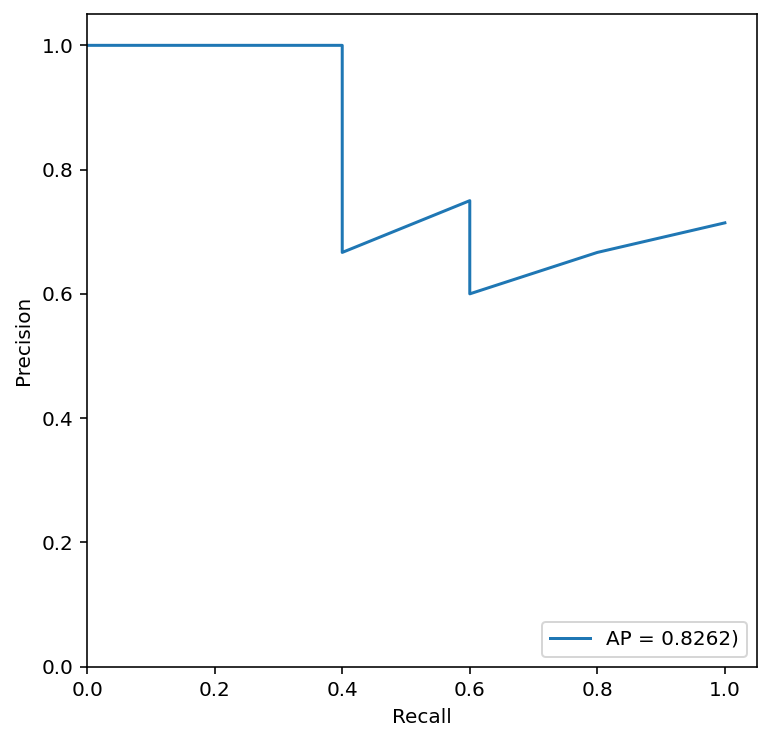

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
prec, rcl, thres = precision_recall_curve(y_test, scores_10)
ap = average_precision_score(y_test, scores_10)
plt.figure(figsize=(6,6))
plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [12]:
# Precision-Recall 테이블 
PR = pd.DataFrame({"precision":prec[::-1], "recall":rcl[::-1]}).round(2)
PR

,precision,recall
0,1.00,0.0
1,1.00,0.2
2,1.00,0.4
3,0.67,0.4
4,0.75,0.6
5,0.60,0.6
6,0.67,0.8
7,0.71,1.0


<AxesSubplot:>

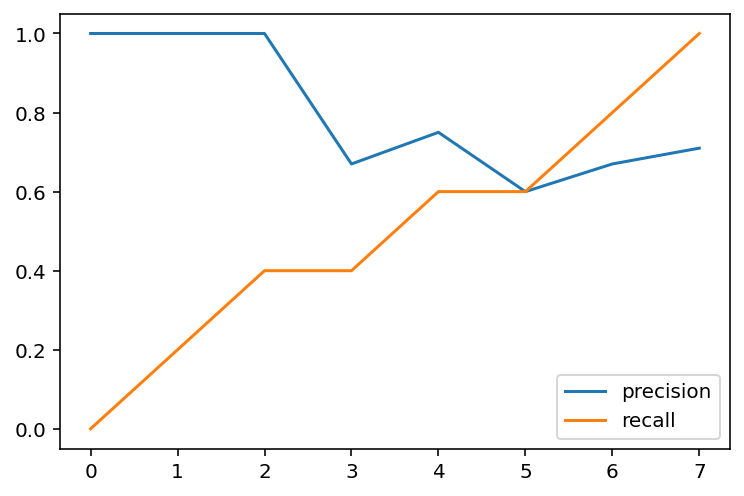

In [13]:
PR.plot()

In [14]:
thres.size

7

In [15]:
# 첫 행은 threshold와 행 갯수를 맞추기 위해서 삭제
PR = PR[1:]

# treshold 컬럼 추가
PR["thres"] = thres[::-1]
PR

<ipython-input-15-a88dfb8a941f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR["thres"] = thres[::-1]


,precision,recall,thres
1,1.00,0.2,96
2,1.00,0.4,86
3,0.67,0.4,82
4,0.75,0.6,70
5,0.60,0.6,64
6,0.67,0.8,61
7,0.71,1.0,52


## P-R 커브의 용도
- ROC-AUC는 분류의 성능을 종합적으로 평가하는데 사용되고
- P-R 커브는 원하는 최소한의 정밀도 또는 리콜 값을 만족하는 분류기를 찾을 때 사용한다
- 문제마다 정밀도가 높아야 하는 경우와 리콜이 높아야 하는 경우가 있다
 - (예) 스팸 메일을 찾아서 스팸함으로 보내는 분류기는 정밀도가 높아야 한다
 - 암을 찾는 작업은 리콜이 높아야 한다
- 동시에 정밀도와 리콜을 높이는 것이 어려우므로 (완벽한 모델이 아니면) 정밀도와 리콜 중 하나의 조건을 우선 만족하면서 다른 값이 가능한 높은 모델을 채택해야 한다
 - 이러한 조건을 만족하는 적절한 분류 경계치를 선택해야 하는 일이 많다
 
- 일반적으로 Precision의 평균치 (mAP: mean Average Precision) 값이 클수록 전체적으로 성능이 좋은 모델이다

# 최적의 분류 경계치 찾기

- 남여 성별 분류 문제에서 P-R 커브를 사용하여 정밀도 또는 리콜의 특정 조건을 만족하는 최적의 threshold 값을 찾는 방법을 소개한다

## 데이터 다운로드

In [16]:
data = pd.read_csv("https://github.com/data-labs/data/raw/main/weight-height.csv")

# 성별 인코딩 (남:0, 여:1)
data.Gender = data.Gender.map({'Male':0, 'Female':1})
# 단위 변환 (인치, 파운드 --> cm, kg)
data.Height = data.Height*2.54 # cm
data.Weight = data.Weight*0.453592 # kg

# 원본 백업
df = data.copy()

##  성별  예측
- X: 키와 몸무게 (2개의 특성 사용)
- y: 성별 (이진 분류 문제)

In [17]:
X = df[["Height", "Weight"]]
y = df.Gender

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 선형 분류 모델 생성 및 학습
from sklearn.linear_model import SGDClassifier
model = SGDClassifier() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련
model.score(X_test, y_test) # (3) 평가 (정확도)

0.9064

## 분류 기본 성능 평가

In [18]:
# 성별 예측치
y_pred = model.predict(X_test)
show_clf_result(y_test, y_pred)

[[1073  185]
 [  49 1193]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1258
           1       0.87      0.96      0.91      1242

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500



## ROC-AUC
- 먼저 분류 점수 또는 확률을 얻은 후에 ROC 커브를 그린다

In [19]:
# 선형 분류 모델에서 의사결정에 사용한 "점수"를 얻는 함수: decision_function()
scores_cancer = model.decision_function(X_test)

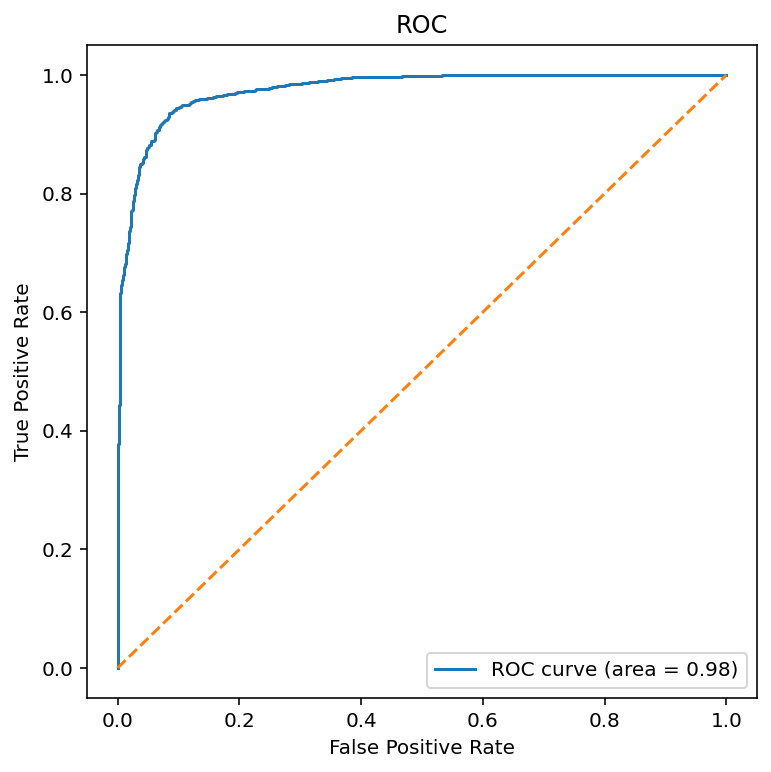

In [20]:
fpr, tpr, _ = roc_curve(y_test, scores_cancer)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [21]:
# 점수순으로 소팅한 테이블 Z 만들기
Z = pd.DataFrame({"y_pred":y_pred, 
                  "y_test":y_test, "scores":scores_cancer}) 
Z = Z.sort_values(by=['scores'], ascending=False)
Z

,y_pred,y_test,scores
8241,1,1,1266.168101
5026,1,1,1145.122552
5191,1,1,1139.144555
7215,1,1,1133.589255
7974,1,1,1110.462540
...,...,...,...
3918,0,0,-1060.010824
1154,0,0,-1070.779864
3090,0,0,-1128.103513
3285,0,0,-1176.660600


In [23]:
# 점수의 최소치를 0으로 최대치를 1로 스케일링한 컬럼 추가 (그래프를 보기 좋게)
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
Z["scores_sc"] = minmax.fit_transform(Z.scores.values.reshape(-1,1))
Z

,y_pred,y_test,scores,scores_sc
8241,1,1,1266.168101,1.000000
5026,1,1,1145.122552,0.951431
5191,1,1,1139.144555,0.949032
7215,1,1,1133.589255,0.946803
7974,1,1,1110.462540,0.937524
...,...,...,...,...
3918,0,0,-1060.010824,0.066629
1154,0,0,-1070.779864,0.062308
3090,0,0,-1128.103513,0.039307
3285,0,0,-1176.660600,0.019823


## 예측값, 실제값, 분류 경계치(threshold) 보기

- 예측값: 파란 선
- 실제값: 붉은 점
- 분류 경계치: 검정색 

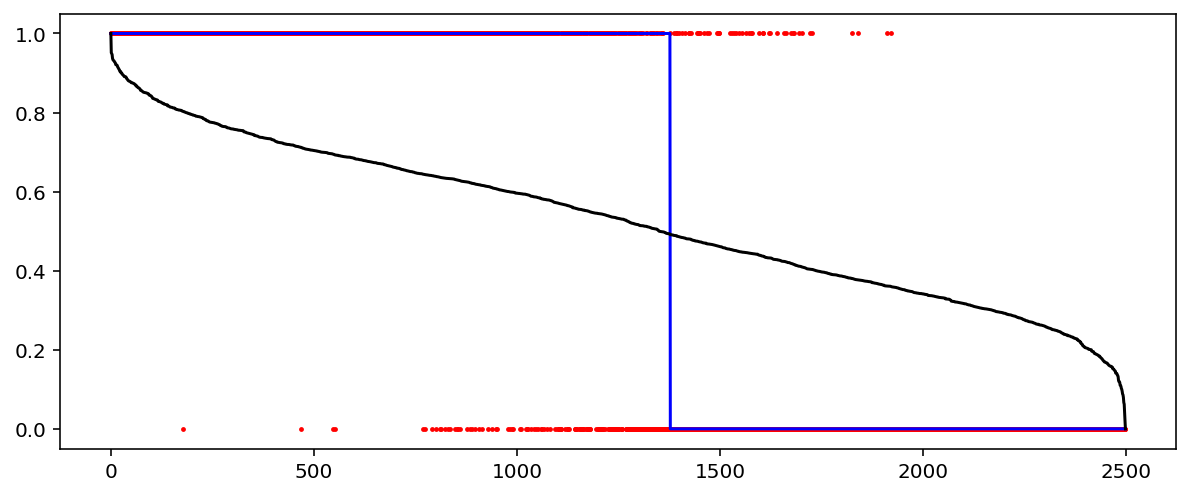

In [24]:
N = 2500
# N = 100
plt.figure(figsize=(10,4))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(Z.y_pred.values[:N], c='b')
plt.plot(Z.scores_sc.values[:N], c='k')

## Precision-Recall 커브

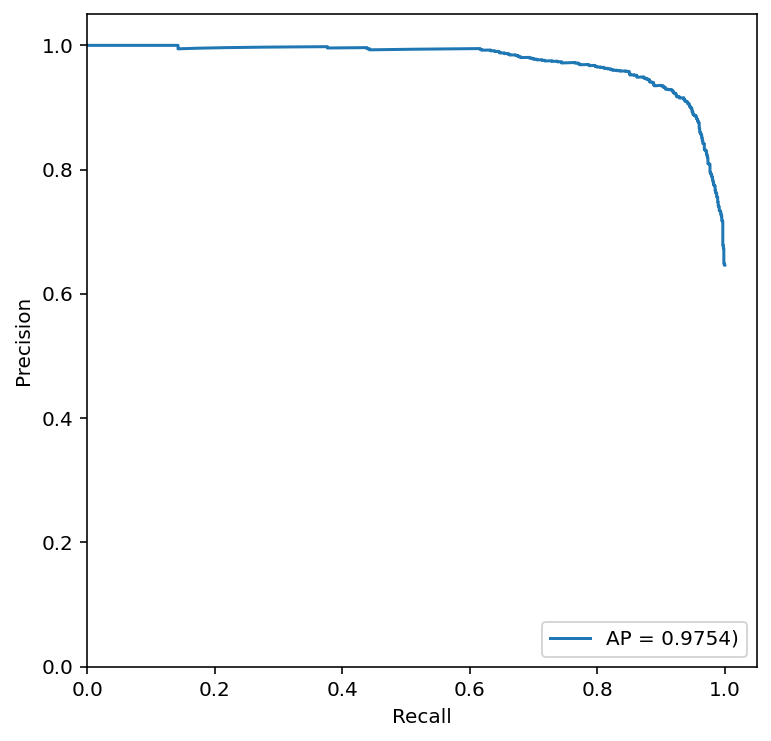

In [25]:
prec, rcl, thres = precision_recall_curve(Z.y_test, Z.scores)
ap = average_precision_score(Z.y_test, Z.scores)
plt.figure(figsize=(6,6))
plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

###  precision_recall 테이블
- 정밀도, 리콜, 경계치 세가지 값을 리턴한다
- P-R 테이블 보기 (리콜이 1인 곳의 값부터 보여준다: 위 P-R 그래프의 우하단부터)
- 검증 데이터 2500개 중에 1922개의 샘플까지만 테이블에 들어있다
- 리콜이 1에 도달한 이후는 더 그릴 필요가 없음

In [26]:
# 정밀도, 리콜 테이블
PR = pd.DataFrame({"precision":prec[::-1], "recall":rcl[::-1]})
PR

,precision,recall
0,1.000000,0.000000
1,1.000000,0.000805
2,1.000000,0.001610
3,1.000000,0.002415
4,1.000000,0.003221
...,...,...
1918,0.647028,0.999195
1919,0.646691,0.999195
1920,0.646354,0.999195
1921,0.646018,0.999195


<AxesSubplot:>

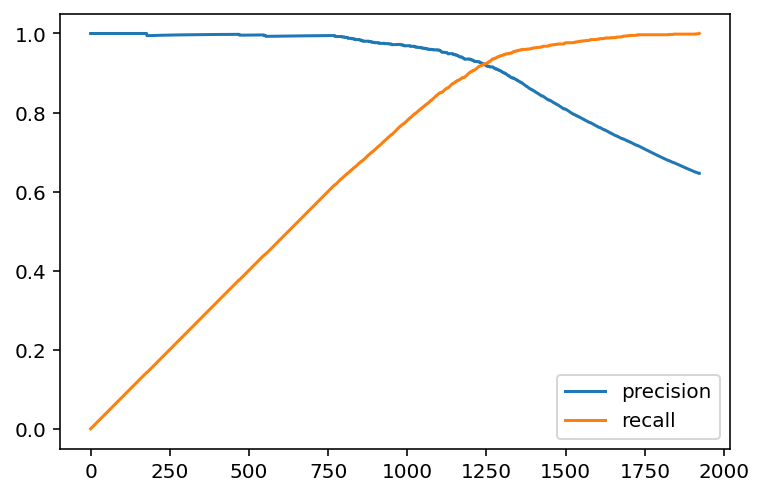

In [27]:
# P-R 테이블 내용을 그래프로 보기
PR.plot()

In [28]:
# PR 테이블의 첫 행은 삭제 (threshold와 행 갯수를 맞추기 위해서)
PR = PR[1:]
# treshold 컬럼 추가
PR["thres"] = thres[::-1]
PR

<ipython-input-28-6ad453a0c675>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR["thres"] = thres[::-1]


,precision,recall,thres
1,1.000000,0.000805,1266.168101
2,1.000000,0.001610,1145.122552
3,1.000000,0.002415,1139.144555
4,1.000000,0.003221,1133.589255
5,1.000000,0.004026,1110.462540
...,...,...,...
1918,0.647028,0.999195,-326.766583
1919,0.646691,0.999195,-326.855389
1920,0.646354,0.999195,-327.233638
1921,0.646018,0.999195,-327.262918


## 최소한의 리콜값 조건을 우선 선택하는 경우

In [29]:
PR[1700:1710]

,precision,recall,thres
1701,0.726044,0.994364,-203.727935
1702,0.725617,0.994364,-203.939712
1703,0.725191,0.994364,-205.586207
1704,0.725352,0.995169,-206.244157
1705,0.724927,0.995169,-207.443555
1706,0.724502,0.995169,-207.724978
1707,0.724077,0.995169,-208.085575
1708,0.723653,0.995169,-209.494611
1709,0.723230,0.995169,-210.201309
1710,0.722807,0.995169,-210.562262


In [30]:
# PR 테이블을 위에서부터 검색하여 처음으로 리콜값을 만족하는 지점을 argmax로 찾는다 (False 에서 처음으로 True가 되는 지점)
recall_min = 0.995 # 원하는 리콜 최소값
thres_cut = np.argmax(PR.recall >= recall_min)+1 # 조건을 만족하는 첫번째 위치
print(thres_cut)

1704


In [31]:
print("해당 지점 이전의 리콜", PR.recall[thres_cut-1])
print("해당 지점의 리콜", PR.recall[thres_cut])
print("해당 지점의 정밀도", PR.precision[thres_cut])
print("경계치 (threshold):", PR.thres[thres_cut])

해당 지점 이전의 리콜 0.9943639291465378
해당 지점의 리콜 0.9951690821256038
해당 지점의 정밀도 0.7253521126760564
경계치 (threshold): -206.24415722348016


In [32]:
# 새로운 분류 경계치 thres_cut를 사용하여 분류를 다시 수행한다
new_y_pred = Z["scores"] >= PR.thres[thres_cut]
new_y_pred

8241     True
5026     True
5191     True
7215     True
7974     True
        ...  
3918    False
1154    False
3090    False
3285    False
1506    False
Name: scores, Length: 2500, dtype: bool

In [33]:
# 예측값이 True인 샘플만의 인덱스 얻기
new_index = new_y_pred.index[new_y_pred]

In [34]:
len(new_index)

1704

In [35]:
new_index[:10]

Int64Index([8241, 5026, 5191, 7215, 7974, 8104, 8620, 6966, 5069, 8692], dtype='int64')

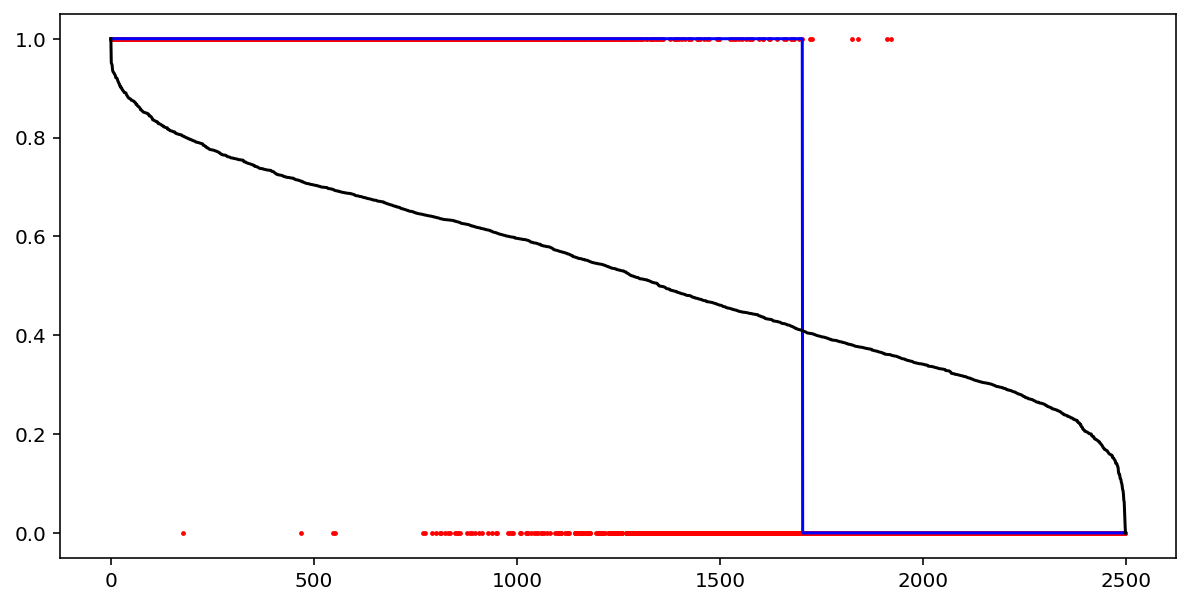

In [36]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
N = 2500
plt.figure(figsize=(10,5))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(new_y_pred.values[:N], c='b')
plt.plot(Z.scores_sc.values[:N], c='k')

In [37]:
Z

,y_pred,y_test,scores,scores_sc
8241,1,1,1266.168101,1.000000
5026,1,1,1145.122552,0.951431
5191,1,1,1139.144555,0.949032
7215,1,1,1133.589255,0.946803
7974,1,1,1110.462540,0.937524
...,...,...,...,...
3918,0,0,-1060.010824,0.066629
1154,0,0,-1070.779864,0.062308
3090,0,0,-1128.103513,0.039307
3285,0,0,-1176.660600,0.019823


In [38]:
show_clf_result(Z.y_test, new_y_pred)

[[ 790  468]
 [   6 1236]]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1258
           1       0.73      1.00      0.84      1242

    accuracy                           0.81      2500
   macro avg       0.86      0.81      0.80      2500
weighted avg       0.86      0.81      0.80      2500



## 최소한의 정밀도를 우선 선택하는 경우

In [39]:
prec_min = 0.99
thres_cut = np.argmax(PR.precision < prec_min)

In [40]:
print("해당 지점의 정밀도", PR.precision[thres_cut])
print("해당 지점 다음 샘플의 정밀도", PR.precision[thres_cut+1])
print("해당 지점의 리콜", PR.recall[thres_cut])
print("경계치 threshold (이상):", PR.thres[thres_cut])
print(thres_cut)

해당 지점의 정밀도 0.9901234567901235
해당 지점 다음 샘플의 정밀도 0.9889025893958077
해당 지점의 리콜 0.6457326892109501
경계치 threshold (이상): 360.66564029874326
810


In [41]:
# 새로운 예측치
new_y_pred = Z["scores"] >= PR.thres[thres_cut]
# 1로 예측된 샘플수
new_y_pred.sum()

810

In [42]:
# 새로운 예측값의 인덱스 얻기
new_index = new_y_pred.index[new_y_pred].tolist()
len(new_index)

810

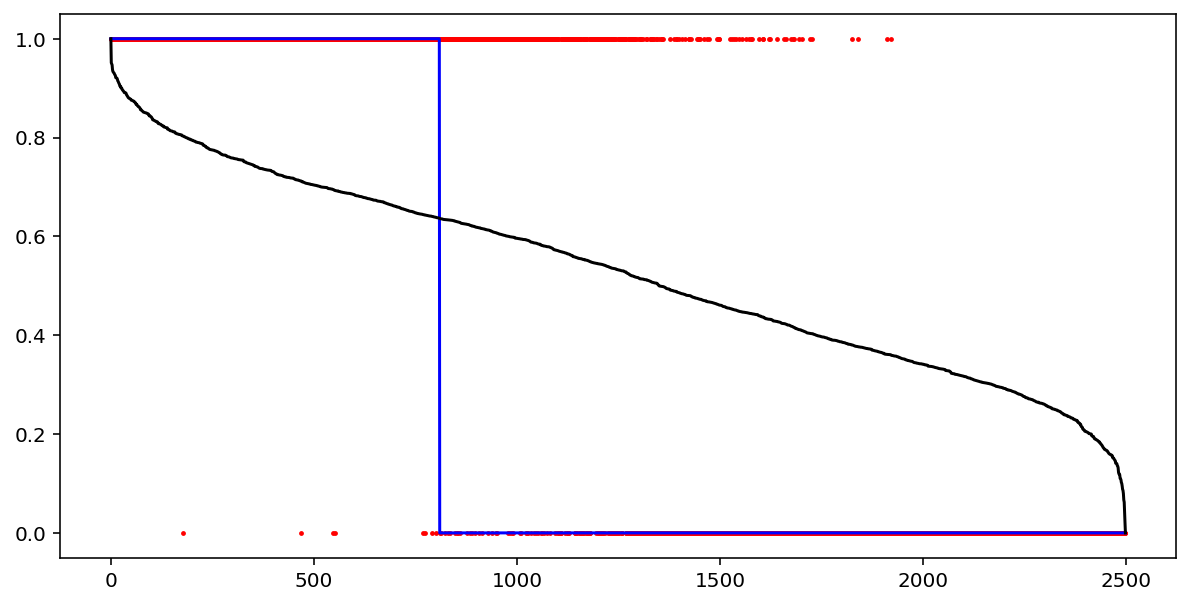

In [43]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
N = 2500
plt.figure(figsize=(10,5))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(new_y_pred.values[:N], c='b')
plt.plot(Z.scores_sc.values[:N], c='k')